## Dependencies

In [1]:
# Tensorflow
import tensorflow as tf
print('Tested with TensorFlow 1.2.0')
print('Your TensorFlow version:', tf.__version__) 

# Feeding function for enqueue data
from tensorflow.python.estimator.inputs.queues import feeding_functions as ff

# Rnn common functions
from tensorflow.contrib.learn.python.learn.estimators import rnn_common

# Model builder
from tensorflow.python.estimator import model_fn as model_fn_lib

# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Helpers for data processing
import pandas as pd
import numpy as np
import argparse
import random

Tested with TensorFLow 1.2.0
Your TensorFlow version: 1.2.0


## Loading Data

First, we want to create our word vectors. For simplicity, we're going to be using a pretrained model. 

As one of the biggest players in the ML game, Google was able to train a Word2Vec model on a massive Google News dataset that contained over 100 billion different words! From that model, Google [was able to create 3 million word vectors](https://code.google.com/archive/p/word2vec/#Pre-trained_word_and_phrase_vectors), each with a dimensionality of 300. 

In an ideal scenario, we'd use those vectors, but since the word vectors matrix is quite large (3.6 GB!), we'll be using a much more manageable matrix that is trained using [GloVe](http://nlp.stanford.edu/projects/glove/), a similar word vector generation model. The matrix will contain 400,000 word vectors, each with a dimensionality of 50. 

We're going to be importing two different data structures, one will be a Python list with the 400,000 words, and one will be a 400,000 x 50 dimensional embedding matrix that holds all of the word vector values. 

In [2]:
# data from: http://ai.stanford.edu/~amaas/data/sentiment/
TRAIN_INPUT = 'data/train.csv'
TEST_INPUT = 'data/test.csv'

# data manually generated
MY_TEST_INPUT = 'data/mytest.csv'

# wordtovec
# https://nlp.stanford.edu/projects/glove/
# the matrix will contain 400,000 word vectors, each with a dimensionality of 50.
word_list = np.load('word_list.npy')
word_list = word_list.tolist() # originally loaded as numpy array
word_list = [word.decode('UTF-8') for word in word_list] # encode words as UTF-8
print('Loaded the word list, length:', len(word_list))

word_vector = np.load('word_vector.npy')
print ('Loaded the word vector, shape:', word_vector.shape)

Loaded the word list, length: 400000
Loaded the word vector, shape: (400000, 50)


We can search our word list for a word like "baseball", and then access its corresponding vector through the embedding matrix.

In [3]:
baseball_index = word_list.index('baseball')
print('Example: baseball')
print(word_vector[baseball_index])

Example: baseball
[-1.93270004  1.04209995 -0.78514999  0.91033     0.22711    -0.62158
 -1.64929998  0.07686    -0.58679998  0.058831    0.35628     0.68915999
 -0.50598001  0.70472997  1.26639998 -0.40031001 -0.020687    0.80862999
 -0.90565997 -0.074054   -0.87674999 -0.62910002 -0.12684999  0.11524
 -0.55685002 -1.68260002 -0.26291001  0.22632     0.713      -1.08280003
  2.12310004  0.49869001  0.066711   -0.48225999 -0.17896999  0.47699001
  0.16384     0.16537    -0.11506    -0.15962    -0.94926    -0.42833
 -0.59456998  1.35660005 -0.27506     0.19918001 -0.36008     0.55667001
 -0.70314997  0.17157   ]


Now that we have our vectors, our first step is taking an input sentence and then constructing the its vector representation. Let's say that we have the input sentence "I thought the movie was incredible and inspiring". In order to get the word vectors, we can use Tensorflow's embedding lookup function. This function takes in two arguments, one for the embedding matrix (the wordVectors matrix in our case), and one for the ids of each of the words. The ids vector can be thought of as the integerized representation of the training set. This is basically just the row index of each of the words. Let's look at a quick example to make this concrete. 

In [92]:
max_seq_length = 10 # maximum length of sentence
num_dims = 50 # dimensions for each word vector

first_sentence = np.zeros((max_seq_length), dtype='int32')
first_sentence[0] = word_list.index("i")
first_sentence[1] = word_list.index("thought")
first_sentence[2] = word_list.index("the")
first_sentence[3] = word_list.index("movie")
first_sentence[4] = word_list.index("was")
first_sentence[5] = word_list.index("incredible")
first_sentence[6] = word_list.index("and")
first_sentence[7] = word_list.index("inspiring")
# first_sentence[8] = 0
# first_sentence[9] = 0

print(first_sentence.shape)
print(first_sentence) # shows the row index for each word

(10,)
[    41    804 201534   1005     15   7446      5  13767      0      0]


###TODO### Insert image

The 10 x 50 output should contain the 50 dimensional word vectors for each of the 10 words in the sequence. 

In [5]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(word_vector, first_sentence).eval().shape)

(10, 50)


Before creating the ids matrix for the whole training set, let’s first take some time to visualize the type of data that we have. This will help us determine the best value for setting our maximum sequence length. In the previous example, we used a max length of 10, but this value is largely dependent on the inputs you have.  

The training set we're going to use is the Imdb movie review dataset. This set has 25,000 movie reviews, with 12,500 positive reviews and 12,500 negative reviews. Each of the reviews is stored in a txt file that we need to parse through. The positive reviews are stored in one directory and the negative reviews are stored in another. The following piece of code will determine total and average number of words in each review. 

In [6]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['positiveReviews/' + f for f in listdir('positiveReviews/') if isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in listdir('negativeReviews/') if isfile(join('negativeReviews/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
The total number of files is 25000
The total number of words in the files is 5844680
The average number of words in the files is 233.7872


We can also use the Matplot library to visualize this data in a histogram format. 

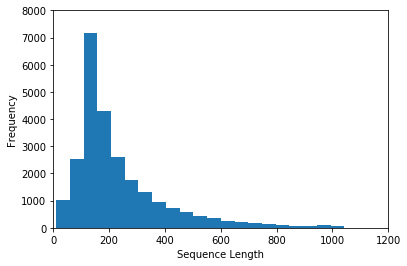

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

From the histogram as well as the average number of words per file, we can safely say that most reviews will fall under 250 words, which is the max sequence length value we will set. 

In [8]:
max_seq_len = 250

### Data

In [73]:
ids_matrix = np.load('ids_matrix.npy').tolist()

## Parameters

In [80]:
# Parameters for training
STEPS = 15000
BATCH_SIZE = 32

# Parameters for data processing
REVIEW_KEY = 'review'
SEQUENCE_LENGTH_KEY = 'sequence_length'

## Separating train and test data

The training set we're going to use is the Imdb movie review dataset. This set has 25,000 movie reviews, with 12,500 positive reviews and 12,500 negative reviews. 

Let's first give a positive label [1, 0] to the first 12500 reviews, and a negative label [0, 1] to the other reviews.

In [75]:
POSITIVE_REVIEWS = 12500

# copying sequences
data_sequences = [np.asarray(v, dtype=np.int32) for v in ids_matrix]
# generating labels
data_labels = [[1, 0] if i < POSITIVE_REVIEWS else [0, 1] for i in range(len(ids_matrix))]
# also creating a length column, this will be used by the Dynamic RNN
# see more about it here: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
data_length = [max_seq_len for i in range(len(ids_matrix))]

Then, let's shuffle the data and use 90% of the reviews for training and the other 10% for testing.

In [76]:
data = list(zip(data_sequences, data_labels, data_length))
random.shuffle(data) # shuffle

data = np.asarray(data)
# separating train and test data
limit = int(len(data) * 0.9)

train_data = data[:limit]
test_data = data[limit:]

### Verifying if the train and test data have enough positive and negative examples

In [77]:
LABEL_INDEX = 1
def _number_of_pos_labels(df):
    pos_labels = 0
    for value in df:
        if value[LABEL_INDEX] == [1, 0]:
            pos_labels += 1
    return pos_labels

pos_labels_train = _number_of_pos_labels(train_data)
total_labels_train = len(train_data)

pos_labels_test = _number_of_pos_labels(test_data)
total_labels_test = len(test_data)

print('Total number of positive labels:', pos_labels_train + pos_labels_test)
print('Proportion of positive labels on the Train data:', pos_labels_train/total_labels_train)
print('Proportion of positive labels on the Test data:', pos_labels_test/total_labels_test)

Total number of positive labels: 12500
Proportion of positive labels on the Train data: 0.49933333333333335
Proportion of positive labels on the Test data: 0.506


## Input functions

In [159]:
def get_input_fn(df, batch_size, num_epochs=1, shuffle=True):  
    def input_fn():
        
        sequences = np.asarray([v for v in df[:,0]], dtype=np.int32)
        labels = np.asarray([v for v in df[:,1]], dtype=np.int32)
        length = np.asarray(df[:,2], dtype=np.int32)

        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data
        dataset = (
            tf.contrib.data.Dataset.from_tensor_slices((sequences, labels, length)) # reading data from memory
            .repeat(num_epochs) # repeat dataset the number of epochs
            .batch(batch_size)
        )
        
        # for our "manual" test we don't want to shuffle the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100000)

        # create iterator
        review, label, length = dataset.make_one_shot_iterator().get_next()

        features = {
            REVIEW_KEY: review,
            SEQUENCE_LENGTH_KEY: length,
        }

        return features, label
    return input_fn

In [160]:
features, label = get_input_fn(test_data, 2, shuffle=False)()

In [161]:
with tf.Session() as sess:
    items = sess.run(features)
    print(items[REVIEW_KEY])

    print(sess.run(label))


[[    36     29   7503    978    465     10 201534    371     65     34
     102      7  12474      6 201534    621      4    567    264   2500
  201534   1607    153      3 201534    281     14     12     20   2444
       4    480   1003     19   2532   6769     65      5     14   1096
      34    301      5    266     12  21853     44    973      4 201534
    2500      3   1487   7763    439     73     37    102     14    182
     749    164      6      7 399999 106337   3349 399999   1301  99048
   11027     13      7   4706 399999 399999      7    333   1983    151
  201534   1570      3  59651     32  12734 201534    371     19   4424
     142   1670   1222    152    164 399999    992   9742    197    109
     246     86     39    234 201534 399999    635      3 201534  22866
    2913      6 201534 399999  33830  24445   2115 201534    215   8183
     295   2956 217684      4    359 399999    401   4537   2280     46
      36      5     76     34     36    338     65     56    941

In [83]:
train_input_fn = get_input_fn(train_data, BATCH_SIZE, None)
test_input_fn = get_input_fn(test_data, BATCH_SIZE)

## Creating the Estimator model

In [166]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01,
                 embed_dim=128):
    
    def model_fn(features, labels, mode):
        
        review = features[REVIEW_KEY]
        sequence_length = tf.cast(features[SEQUENCE_LENGTH_KEY], tf.int32)

        # Creating embedding
        data = tf.Variable(tf.zeros([BATCH_SIZE, max_seq_len, 50]),dtype=tf.float32)
        data = tf.nn.embedding_lookup(word_vector, review)
        
        # Each RNN layer will consist of a LSTM cell
        rnn_layers = [tf.contrib.rnn.LSTMCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.contrib.rnn.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=data,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs, sequence_length)

        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)
        predictions_softmax = tf.nn.softmax(predictions)
        
        loss = None
        train_op = None
        eval_op = None
        
        preds_op = {
            'prediction': predictions_softmax,
            'label': labels
        }
        
        if mode == tf.contrib.learn.ModeKeys.EVAL:
            eval_op = {
                "accuracy": tf.metrics.accuracy(
                         tf.argmax(input=predictions_softmax, axis=1),
                         tf.argmax(input=labels, axis=1))
            }
        
        if mode != tf.contrib.learn.ModeKeys.INFER:    
            loss = tf.losses.softmax_cross_entropy(labels, predictions)
    
        if mode == tf.contrib.learn.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                          predictions=predictions_softmax,
                                          loss=loss,
                                          train_op=train_op,
                                          eval_metric_ops=eval_op)
    return model_fn

In [167]:
model_fn = get_model_fn(rnn_cell_sizes=[64], # size of the hidden layers
                        label_dimension=2, # since are just 2 classes
                        dnn_layer_sizes=[128, 64], # size of units in the dense layers on top of the RNN
                        optimizer='Adam',
                        learning_rate=0.001,
                        embed_dim=512)

## Create and Run Experiment

In [90]:
# create experiment
def generate_experiment_fn():
  
    """
        Create an experiment function given hyperparameters.
        Returns:
        A function (output_dir) -> Experiment where output_dir is a string
        representing the location of summaries, checkpoints, and exports.
        this function is used by learn_runner to create an Experiment which
        executes model code provided in the form of an Estimator and
        input functions.
        All listed arguments in the outer function are used to create an
        Estimator, and input functions (training, evaluation, serving).
        Unlisted args are passed through to Experiment.
    """

    def _experiment_fn(run_config, hparams):
        estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config)
        return tf.contrib.learn.Experiment(
            estimator,
            train_input_fn=train_input_fn,
            eval_input_fn=test_input_fn,
            train_steps=STEPS
        )
    return _experiment_fn

In [91]:
# run experiment 
learn_runner.run(generate_experiment_fn(), run_config=tf.contrib.learn.RunConfig(model_dir='testing2'))

INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3a18f5a550>, '_tf_random_seed': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_model_dir': 'testing2', '_task_id': 0, '_evaluation_master': '', '_environment': 'local', '_master': '', '_is_chief': True, '_save_checkpoints_secs': 600, '_task_type': None, '_keep_checkpoint_max': 5, '_num_worker_replicas': 0}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
INFO:tensorflow:Create CheckpointSaverHook.


/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Saving checkpoints for 1 into testing2/model.ckpt.
INFO:tensorflow:loss = 0.702224, step = 1
INFO:tensorflow:Starting evaluation at 2017-06-29-13:09:09
INFO:tensorflow:Restoring parameters from testing2/model.ckpt-1
INFO:tensorflow:Evaluation [1/100]
INFO:tensorflow:Evaluation [2/100]
INFO:tensorflow:Evaluation [3/100]
INFO:tensorflow:Evaluation [4/100]
INFO:tensorflow:Evaluation [5/100]
INFO:tensorflow:Evaluation [6/100]
INFO:tensorflow:Evaluation [7/100]
INFO:tensorflow:Evaluation [8/100]
INFO:tensorflow:Evaluation [9/100]
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [11/100]
INFO:tensorflow:Evaluation [12/100]
INFO:tensorflow:Evaluation [13/100]
INFO:tensorflow:Evaluation [14/100]
INFO:tensorflow:Evaluation [15/100]
INFO:tensorflow:Evaluation [16/100]
INFO:tensorflow:Evaluation [17/100]
INFO:tensorflow:Evaluation [18/100]
INFO:tensorflow:Evaluation [19/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [21/100]
INFO:tensorflow:Evalu

INFO:tensorflow:global_step/sec: 10.859
INFO:tensorflow:loss = 0.659731, step = 5101 (9.209 sec)
INFO:tensorflow:global_step/sec: 10.95
INFO:tensorflow:loss = 0.751493, step = 5201 (9.132 sec)
INFO:tensorflow:global_step/sec: 10.8978
INFO:tensorflow:loss = 0.652734, step = 5301 (9.176 sec)
INFO:tensorflow:global_step/sec: 10.6529
INFO:tensorflow:loss = 0.701441, step = 5401 (9.387 sec)
INFO:tensorflow:global_step/sec: 10.6547
INFO:tensorflow:loss = 0.693071, step = 5501 (9.386 sec)
INFO:tensorflow:global_step/sec: 10.549
INFO:tensorflow:loss = 0.692545, step = 5601 (9.480 sec)
INFO:tensorflow:global_step/sec: 10.8424
INFO:tensorflow:loss = 0.680459, step = 5701 (9.223 sec)
INFO:tensorflow:global_step/sec: 10.0042
INFO:tensorflow:loss = 0.693177, step = 5801 (9.996 sec)
INFO:tensorflow:global_step/sec: 10.6846
INFO:tensorflow:loss = 0.696385, step = 5901 (9.359 sec)
INFO:tensorflow:global_step/sec: 10.6851
INFO:tensorflow:loss = 0.694919, step = 6001 (9.359 sec)
INFO:tensorflow:global_s

INFO:tensorflow:loss = 0.316909, step = 10101 (9.550 sec)
INFO:tensorflow:global_step/sec: 10.5245
INFO:tensorflow:loss = 0.251563, step = 10201 (9.502 sec)
INFO:tensorflow:global_step/sec: 10.4461
INFO:tensorflow:loss = 0.344501, step = 10301 (9.573 sec)
INFO:tensorflow:global_step/sec: 10.522
INFO:tensorflow:loss = 0.372052, step = 10401 (9.504 sec)
INFO:tensorflow:global_step/sec: 10.5911
INFO:tensorflow:loss = 0.319963, step = 10501 (9.442 sec)
INFO:tensorflow:global_step/sec: 10.5216
INFO:tensorflow:loss = 0.369244, step = 10601 (9.504 sec)
INFO:tensorflow:global_step/sec: 10.521
INFO:tensorflow:loss = 0.264259, step = 10701 (9.505 sec)
INFO:tensorflow:global_step/sec: 10.5213
INFO:tensorflow:loss = 0.443012, step = 10801 (9.505 sec)
INFO:tensorflow:global_step/sec: 10.522
INFO:tensorflow:loss = 0.328671, step = 10901 (9.504 sec)
INFO:tensorflow:global_step/sec: 10.4649
INFO:tensorflow:loss = 0.370794, step = 11001 (9.556 sec)
INFO:tensorflow:global_step/sec: 10.521
INFO:tensorflo

INFO:tensorflow:global_step/sec: 10.8143
INFO:tensorflow:loss = 0.335126, step = 15101 (9.247 sec)
INFO:tensorflow:global_step/sec: 10.8845
INFO:tensorflow:loss = 0.386393, step = 15201 (9.187 sec)
INFO:tensorflow:global_step/sec: 10.8657
INFO:tensorflow:loss = 0.20567, step = 15301 (9.203 sec)
INFO:tensorflow:global_step/sec: 10.5443
INFO:tensorflow:loss = 0.198978, step = 15401 (9.484 sec)
INFO:tensorflow:global_step/sec: 10.5136
INFO:tensorflow:loss = 0.230477, step = 15501 (9.512 sec)
INFO:tensorflow:global_step/sec: 10.5629
INFO:tensorflow:loss = 0.208272, step = 15601 (9.467 sec)
INFO:tensorflow:global_step/sec: 10.6166
INFO:tensorflow:loss = 0.303766, step = 15701 (9.419 sec)
INFO:tensorflow:global_step/sec: 10.5211
INFO:tensorflow:loss = 0.398745, step = 15801 (9.504 sec)
INFO:tensorflow:global_step/sec: 10.5106
INFO:tensorflow:loss = 0.190603, step = 15901 (9.514 sec)
INFO:tensorflow:global_step/sec: 10.4468
INFO:tensorflow:loss = 0.415988, step = 16001 (9.572 sec)
INFO:tensor

INFO:tensorflow:loss = 0.0573027, step = 20001 (10.158 sec)
INFO:tensorflow:global_step/sec: 10.0328
INFO:tensorflow:loss = 0.14195, step = 20101 (9.967 sec)
INFO:tensorflow:global_step/sec: 9.67057
INFO:tensorflow:loss = 0.262287, step = 20201 (10.341 sec)
INFO:tensorflow:global_step/sec: 9.54714
INFO:tensorflow:loss = 0.102364, step = 20301 (10.474 sec)
INFO:tensorflow:global_step/sec: 10.0709
INFO:tensorflow:loss = 0.0309285, step = 20401 (9.930 sec)
INFO:tensorflow:global_step/sec: 10.0926
INFO:tensorflow:loss = 0.0468883, step = 20501 (9.908 sec)
INFO:tensorflow:global_step/sec: 10.056
INFO:tensorflow:loss = 0.0746669, step = 20601 (9.944 sec)
INFO:tensorflow:global_step/sec: 10.1143
INFO:tensorflow:loss = 0.412788, step = 20701 (9.887 sec)
INFO:tensorflow:global_step/sec: 9.8962
INFO:tensorflow:loss = 0.228101, step = 20801 (10.105 sec)
INFO:tensorflow:global_step/sec: 10.3426
INFO:tensorflow:loss = 0.184479, step = 20901 (9.669 sec)
INFO:tensorflow:global_step/sec: 9.95871
INFO:

INFO:tensorflow:global_step/sec: 6.52353
INFO:tensorflow:loss = 0.0341375, step = 25001 (15.329 sec)
INFO:tensorflow:global_step/sec: 10.0441
INFO:tensorflow:loss = 0.0274761, step = 25101 (9.956 sec)
INFO:tensorflow:global_step/sec: 10.1661
INFO:tensorflow:loss = 0.300942, step = 25201 (9.837 sec)
INFO:tensorflow:global_step/sec: 10.227
INFO:tensorflow:loss = 0.0524202, step = 25301 (9.778 sec)
INFO:tensorflow:global_step/sec: 9.84267
INFO:tensorflow:loss = 0.0874858, step = 25401 (10.160 sec)
INFO:tensorflow:global_step/sec: 9.98989
INFO:tensorflow:loss = 0.380375, step = 25501 (10.010 sec)
INFO:tensorflow:global_step/sec: 10.0228
INFO:tensorflow:loss = 0.167019, step = 25601 (9.977 sec)
INFO:tensorflow:global_step/sec: 10.1635
INFO:tensorflow:loss = 0.10299, step = 25701 (9.839 sec)
INFO:tensorflow:global_step/sec: 9.97289
INFO:tensorflow:loss = 0.0480214, step = 25801 (10.027 sec)
INFO:tensorflow:global_step/sec: 10.1747
INFO:tensorflow:loss = 0.249856, step = 25901 (9.828 sec)
INF

KeyboardInterrupt: 

## Making Predictions

First let's generate our own sentences to see how the model classifies them.

In [188]:
def string_to_array(s, separator=' '):
    return s.split(separator)

def generate_data_row(sentence, label, max_length):
    sequence = np.zeros((max_length), dtype='int32')
    for i, word in enumerate(string_to_array(sentence)):
        sequence[i] = word_list.index(word)
    
    return sequence, label, max_length
    
def generate_data(sentences, labels, max_length):
    data = []
    for s, l in zip(sentences, labels):
        data.append(generate_data_row(s, l, max_length))
    
    return np.asarray(data)


sentences = ['i thought the movie was incredible and inspiring', 
             'this is a great movie',
             'this is a good movie but isnt the best',
             'it was fine i guess',
             'it was definitely bad',
             'its not that bad',
             'its not that bad i think its a good movie',
             'its not bad i think its a good movie']

labels = [[1, 0],
          [1, 0],
          [1, 0],
          [0, 1],
          [0, 1],
          [1, 0],
          [1, 0],
          [1, 0]] # [1, 0]: positive, [0, 1]: negative

my_test_data = generate_data(sentences, labels, 10)

Now, let's generate predictions for the sentences

In [189]:
preds = estimator.predict(input_fn=get_input_fn(my_test_data, 1, 1, shuffle=False))

print()
for p, s in zip(preds, sentences):
    print('sentence:', s)
    print('good review:', p[0], 'bad review:', p[1])
    print('-' * 10)


INFO:tensorflow:Restoring parameters from tensorboard/batch_32/model.ckpt-12547
sentence: i thought the movie was incredible and inspiring
good review: 0.932236 bad review: 0.0677641
----------
sentence: this is a great movie
good review: 0.980506 bad review: 0.0194938
----------
sentence: this is a good movie but isnt the best
good review: 0.926685 bad review: 0.0733154
----------
sentence: it was fine i guess
good review: 0.504088 bad review: 0.495912
----------
sentence: it was definitely bad
good review: 0.0672349 bad review: 0.932765
----------
sentence: its not that bad
good review: 0.234982 bad review: 0.765018
----------
sentence: its not that bad i think its a good movie
good review: 0.323138 bad review: 0.676862
----------
sentence: its not bad i think its a good movie
good review: 0.461568 bad review: 0.538432
----------
